<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Coulomb_Blockades_and_Coulomb_Diamonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is an attempt by Onri Jay Benally at plotting the conductance of a Coulomb blockade in Python using a handful of examples, with changes to the color gradient.

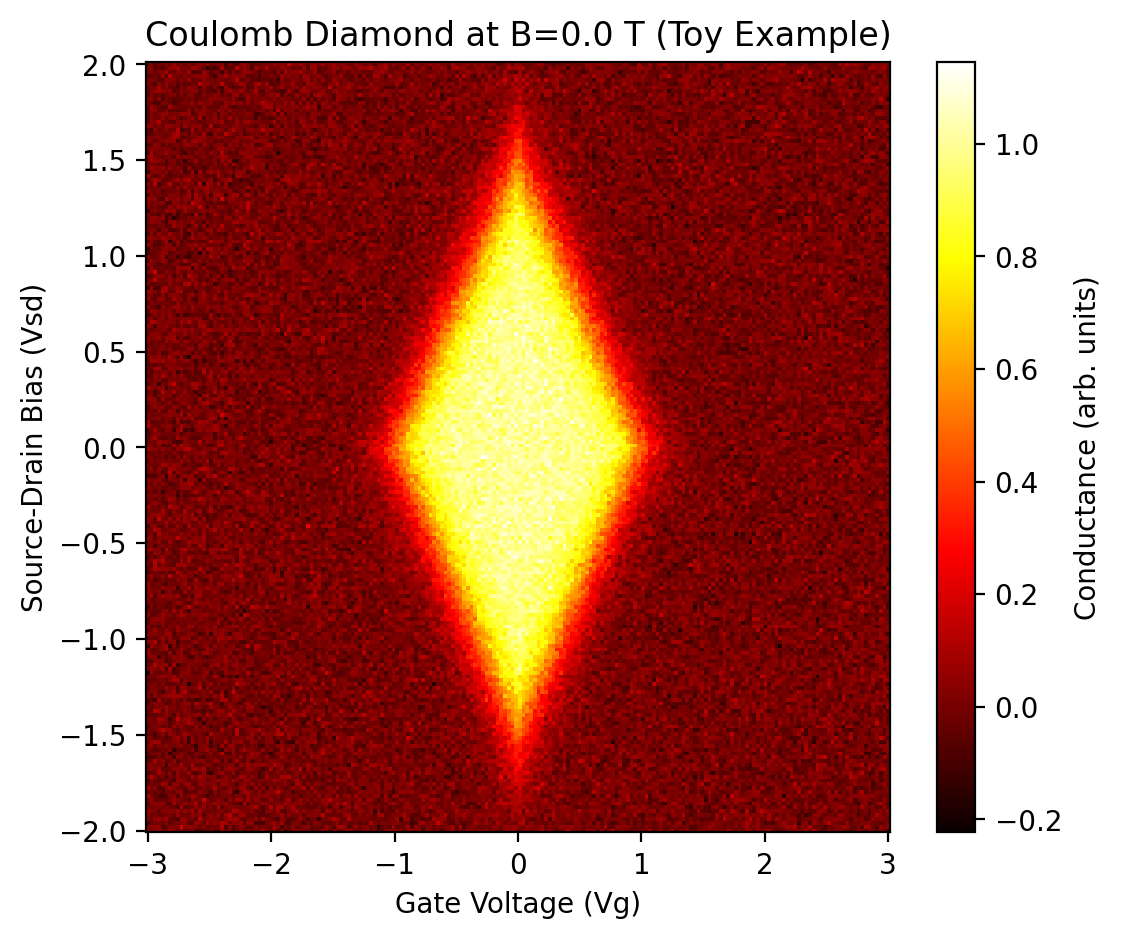

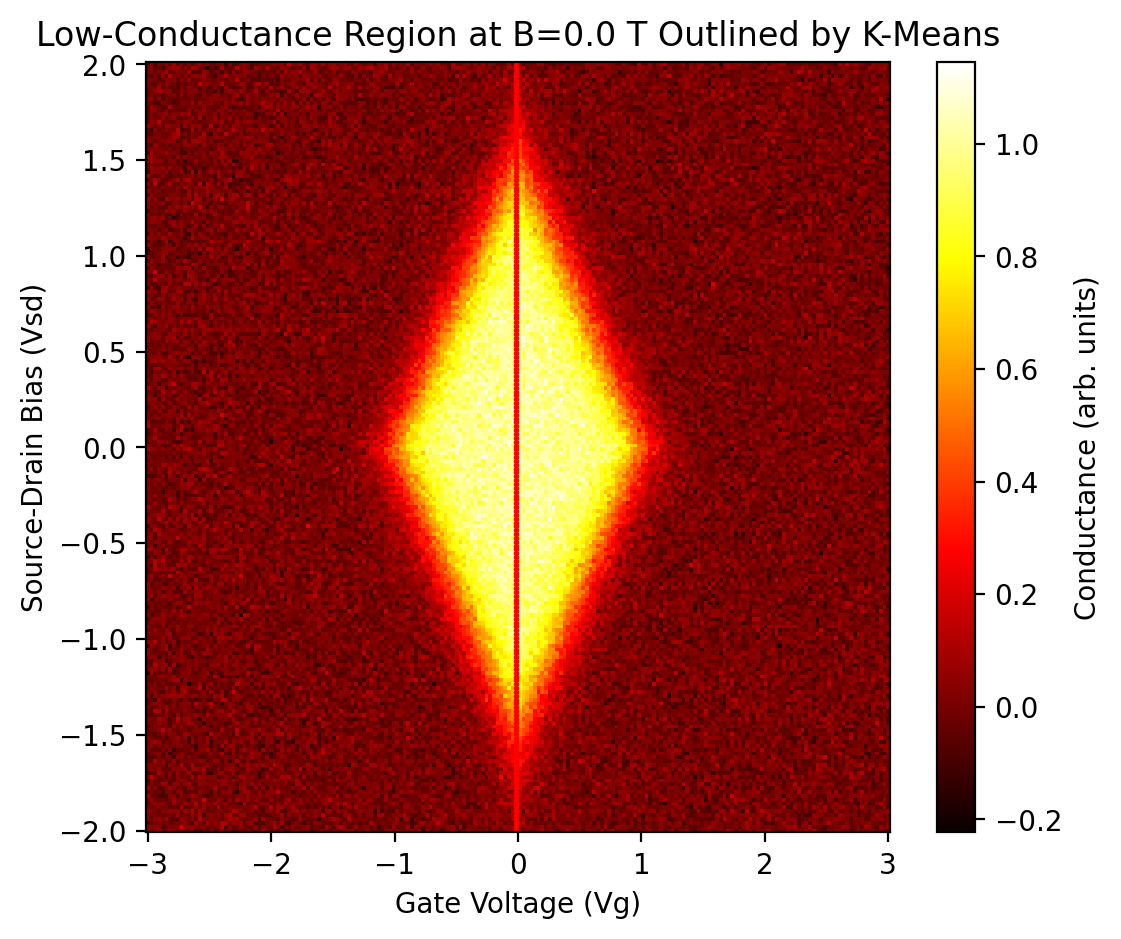

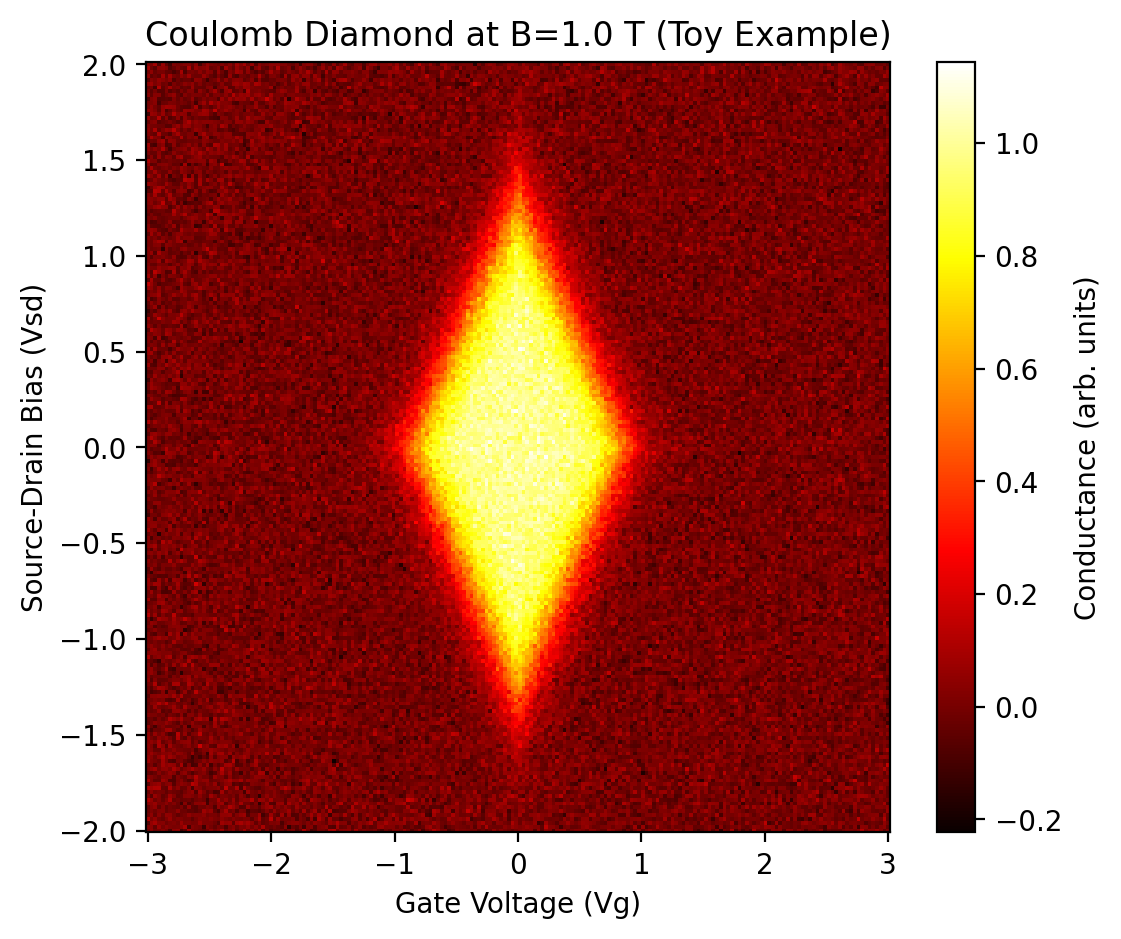

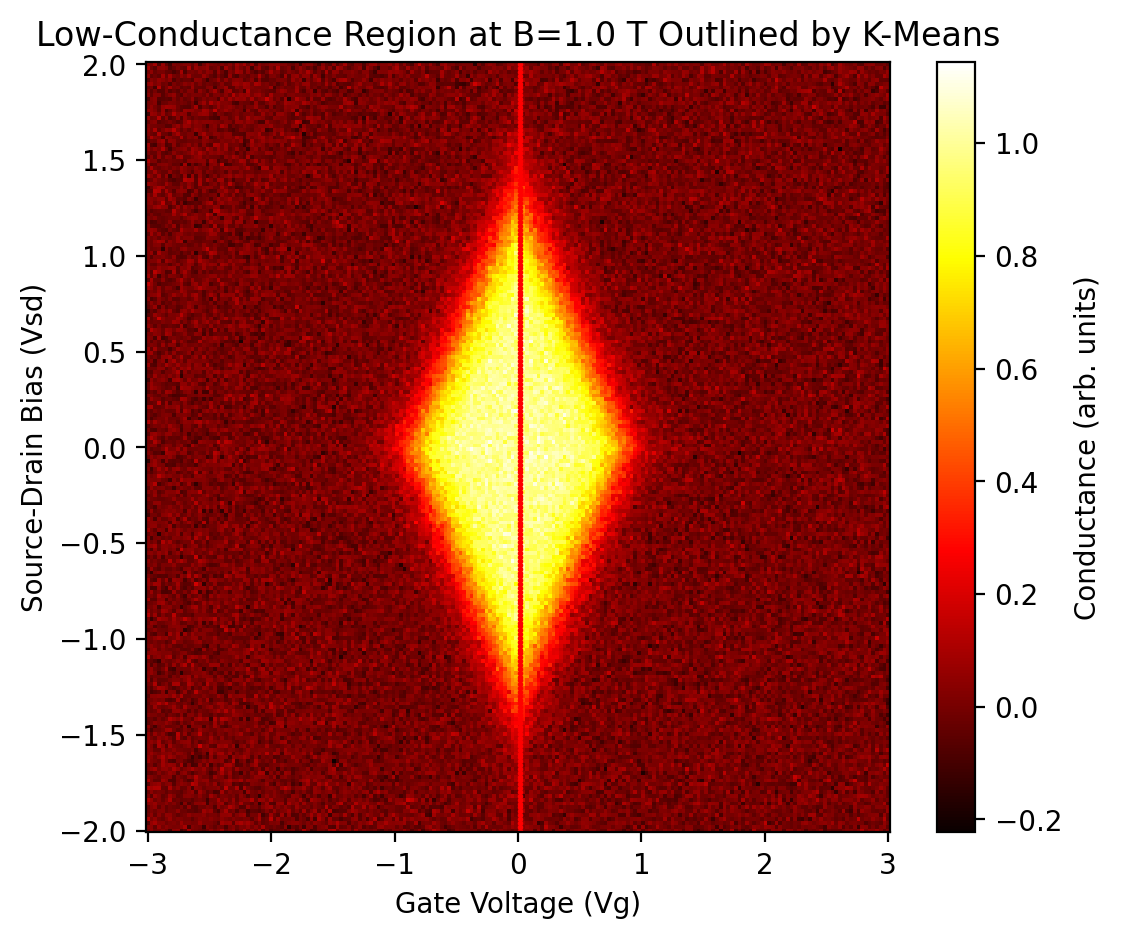

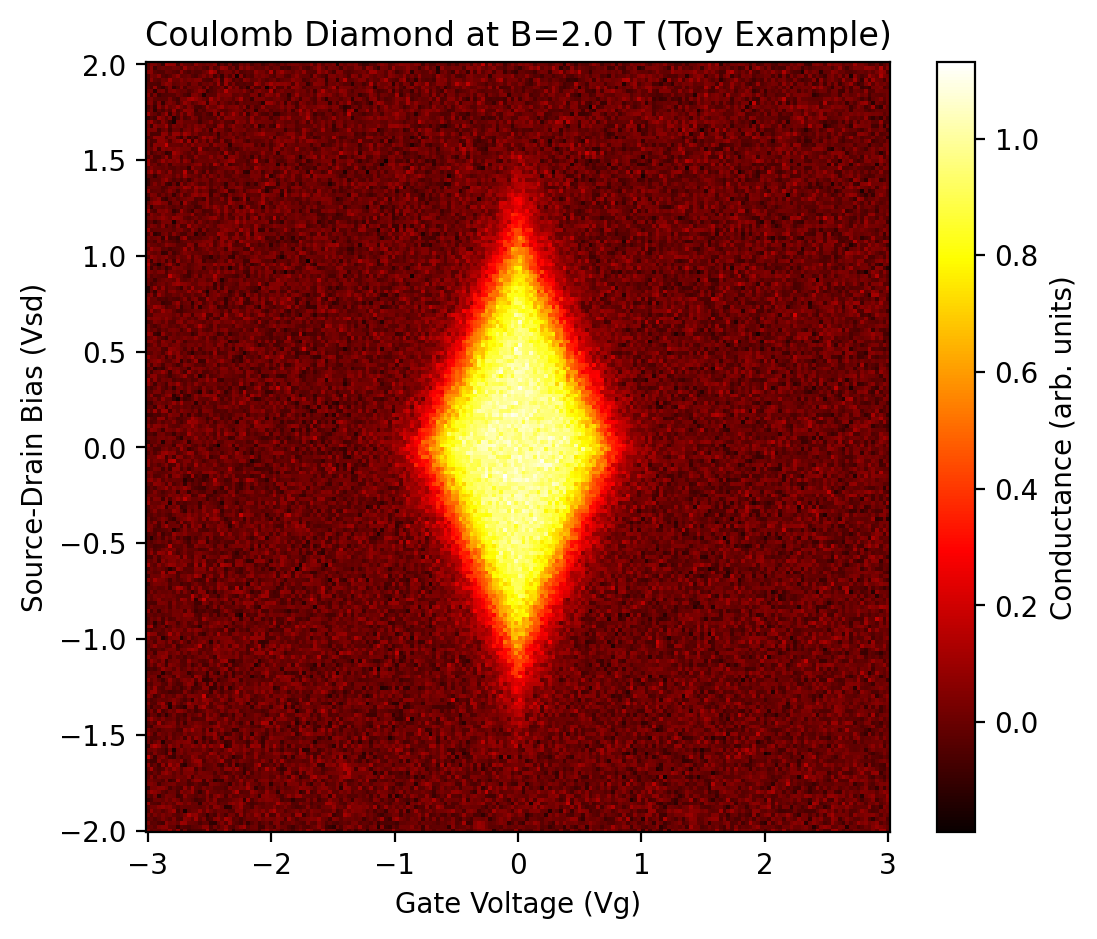

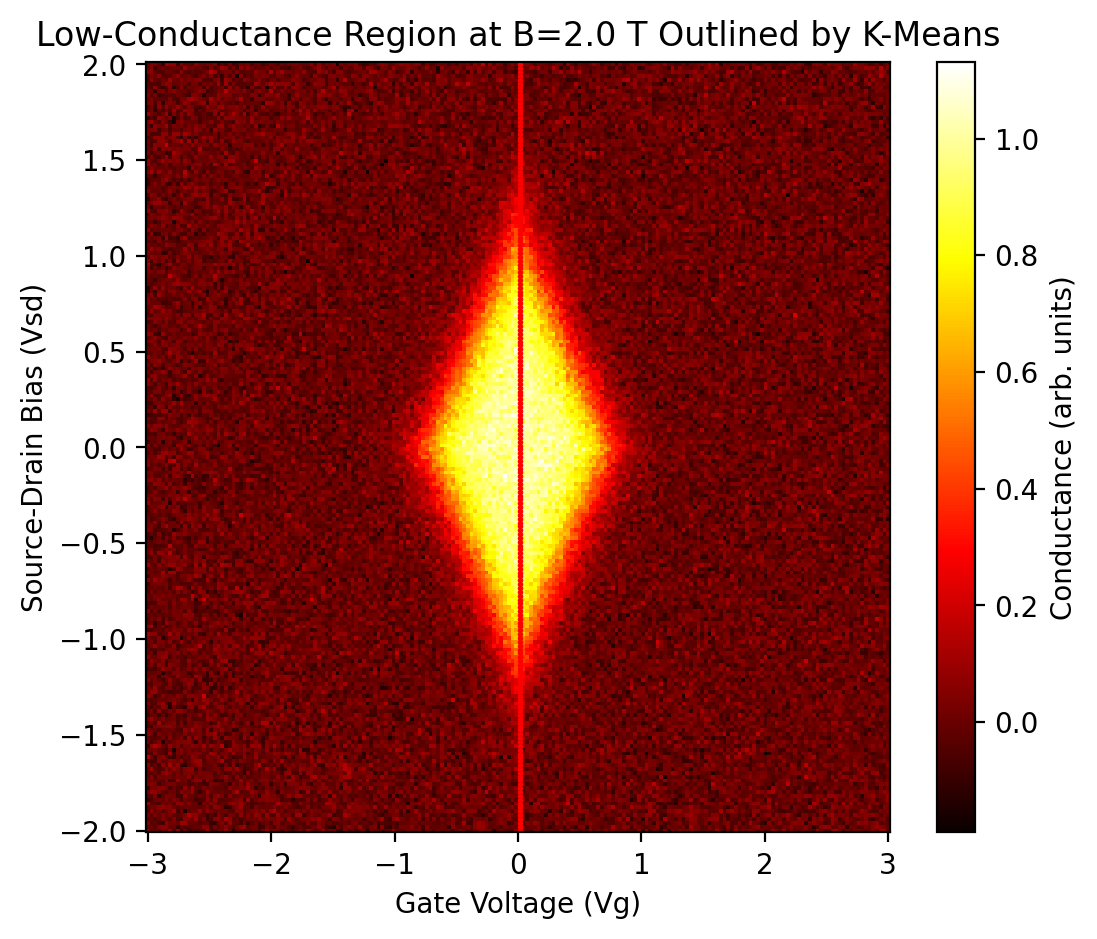

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# Onri prefers using rcParams to increase the quality of all plots to be higher than the default settings.
# This only needs to be done once at beginning of every Jupyter Notebook.
plt.rcParams['figure.dpi'] = 200

# ================================
# 1. Set global parameters
# ================================
np.random.seed(42)

num_points = 200
Vg = np.linspace(-3, 3, num_points)      # Gate voltage range
Vsd = np.linspace(-2, 2, num_points)     # Source-drain bias range
VG, VSD = np.meshgrid(Vg, Vsd)

diamond_half_width_gate = 1.0
diamond_half_width_bias = 1.5
sharpness = 6.0
alpha = diamond_half_width_bias / diamond_half_width_gate

noise_amplitude = 0.05

# "Magnetic penalty" factor: how strongly conduction is suppressed with B
B_penalty_strength = 0.2

# List of magnetic field values to simulate
B_values = [0.0, 1.0, 2.0]

# ================================
# 2. Loop over B values
# ================================
for B in B_values:

    # -----------------------------------------
    # 2.1 Generate synthetic conduction data
    # -----------------------------------------
    # Diamond equation: |Vsd| + alpha*|Vg|
    diamond_condition = np.abs(VSD) + alpha * np.abs(VG)

    # Effective threshold is reduced by an amount proportional to B
    effective_threshold = diamond_half_width_bias - B_penalty_strength * B
    # Conductance function (toy model)
    conductance = 1 / (1 + np.exp(sharpness*(diamond_condition - effective_threshold)))

    # Add noise to simulate experimental data
    conductance_noisy = conductance + noise_amplitude * np.random.randn(*conductance.shape)

    # -----------------------------------------
    # 2.2 Plot the conductance map for each B
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(6,5))
    c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
    ax.set_xlabel('Gate Voltage (Vg)')
    ax.set_ylabel('Source-Drain Bias (Vsd)')
    ax.set_title(f'Coulomb Diamond at B={B} T (Toy Example)')
    fig.colorbar(c, ax=ax, label='Conductance (arb. units)')
    plt.show()

    # ----------------------------------------------------
    # 2.3 K-means clustering to outline blockade region
    # ----------------------------------------------------
    # Flatten the 2D grid to pass data into KMeans
    X_flat = VG.ravel()
    Y_flat = VSD.ravel()
    C_flat = conductance_noisy.ravel()
    data_for_clustering = np.column_stack((X_flat, Y_flat, C_flat))

    # 2-cluster classification: "low" vs. "high" conductance
    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(data_for_clustering)
    labels_2d = labels.reshape(num_points, num_points)

    # Identify which cluster is low conductance
    avg_conductance_in_cluster = []
    for cluster_id in range(2):
        avg_conductance_in_cluster.append(np.mean(C_flat[labels == cluster_id]))
    low_cluster_id = np.argmin(avg_conductance_in_cluster)

    # Create a mask for the low conduction cluster
    low_mask = (labels_2d == low_cluster_id)

    # We make a boundary outline by dilating the mask and taking the XOR
    dilated_mask = binary_dilation(low_mask)
    boundary = dilated_mask ^ low_mask

    # ---------------------------------------------
    # 2.4 Plot the map again with the outline
    # ---------------------------------------------
    fig, ax = plt.subplots(figsize=(6,5))
    c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
    fig.colorbar(c, ax=ax, label='Conductance (arb. units)')

    ax.scatter(VG[boundary], VSD[boundary], color='red', s=1)

    ax.set_xlabel('Gate Voltage (Vg)')
    ax.set_ylabel('Source-Drain Bias (Vsd)')
    ax.set_title(f'Low-Conductance Region at B={B} T Outlined by K-Means')
    plt.show()


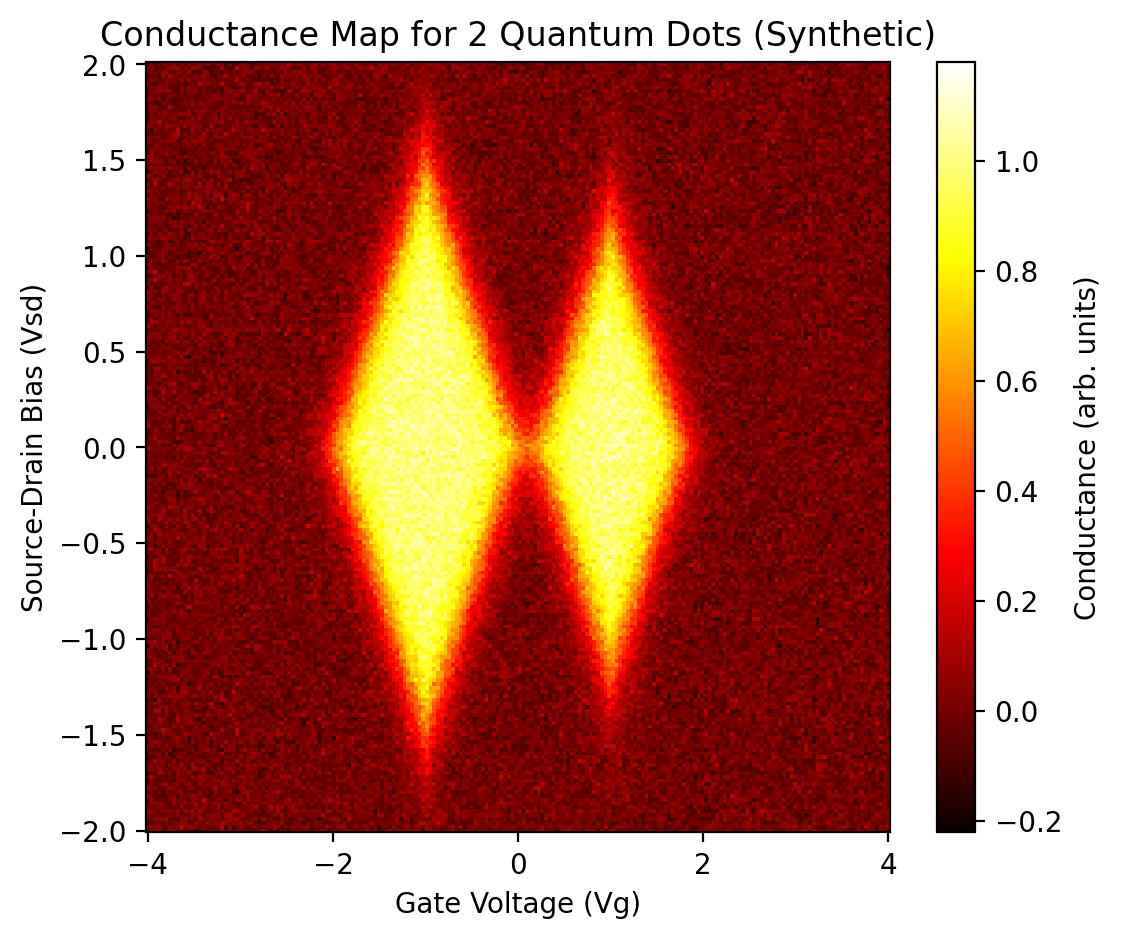

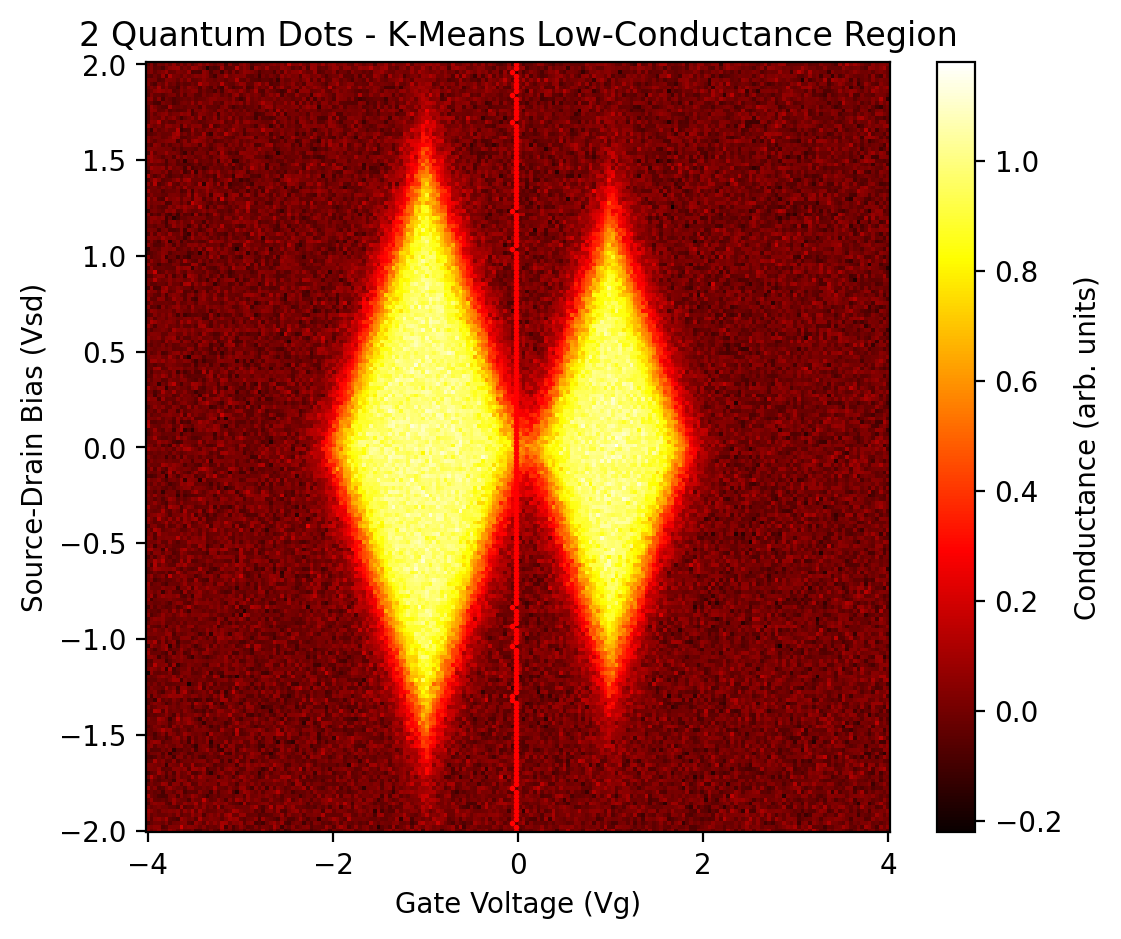

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# ==========================
# 1. Generate synthetic data
# ==========================
np.random.seed(42)

num_points = 200
Vg = np.linspace(-4, 4, num_points)   # Gate voltage from -4 to +4
Vsd = np.linspace(-2, 2, num_points)  # Source-drain bias
VG, VSD = np.meshgrid(Vg, Vsd)

# Dot 1 parameters
diamond_half_width_gate_1 = 1.0
diamond_half_width_bias_1 = 1.5
offset_1 = -1.0         # shift in gate voltage
alpha_1 = diamond_half_width_bias_1 / diamond_half_width_gate_1
sharpness_1 = 6.0

# Dot 2 parameters
diamond_half_width_gate_2 = 0.8
diamond_half_width_bias_2 = 1.2
offset_2 = 1.0          # shift in gate voltage
alpha_2 = diamond_half_width_bias_2 / diamond_half_width_gate_2
sharpness_2 = 6.0

# Define conduction for each dot
# Dot 1 diamond condition
diamond_cond_1 = np.abs(VSD) + alpha_1 * np.abs(VG - offset_1)
conduction_1 = 1 / (1 + np.exp(sharpness_1 * (diamond_cond_1 - diamond_half_width_bias_1)))

# Dot 2 diamond condition
diamond_cond_2 = np.abs(VSD) + alpha_2 * np.abs(VG - offset_2)
conduction_2 = 1 / (1 + np.exp(sharpness_2 * (diamond_cond_2 - diamond_half_width_bias_2)))

# Combine them (simulating parallel conduction from each dot)
conductance = conduction_1 + conduction_2

# Add noise
noise_amplitude = 0.05
conductance_noisy = conductance + noise_amplitude * np.random.randn(*conductance.shape)

# ==========================
# 2. Plot the 2-dot conduction map
# ==========================
fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')
ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('Conductance Map for 2 Quantum Dots (Synthetic)')
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')
plt.show()

# ================================================
# 3. K-means to outline the low-conductance region
# ================================================
X_flat = VG.ravel()
Y_flat = VSD.ravel()
C_flat = conductance_noisy.ravel()
data_for_clustering = np.column_stack((X_flat, Y_flat, C_flat))

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(data_for_clustering)
labels_2d = labels.reshape(num_points, num_points)

# Identify which cluster is "low conduction"
avg_conductance_in_cluster = []
for cluster_id in range(2):
    avg_conductance_in_cluster.append(np.mean(C_flat[labels == cluster_id]))
low_cluster_id = np.argmin(avg_conductance_in_cluster)

low_mask = (labels_2d == low_cluster_id)
dilated_mask = binary_dilation(low_mask)
boundary = dilated_mask ^ low_mask

# Plot again with the outline
fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')

# Outline the low-conductance region in red
ax.scatter(VG[boundary], VSD[boundary], color='red', s=1)

ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('2 Quantum Dots - K-Means Low-Conductance Region')
plt.show()


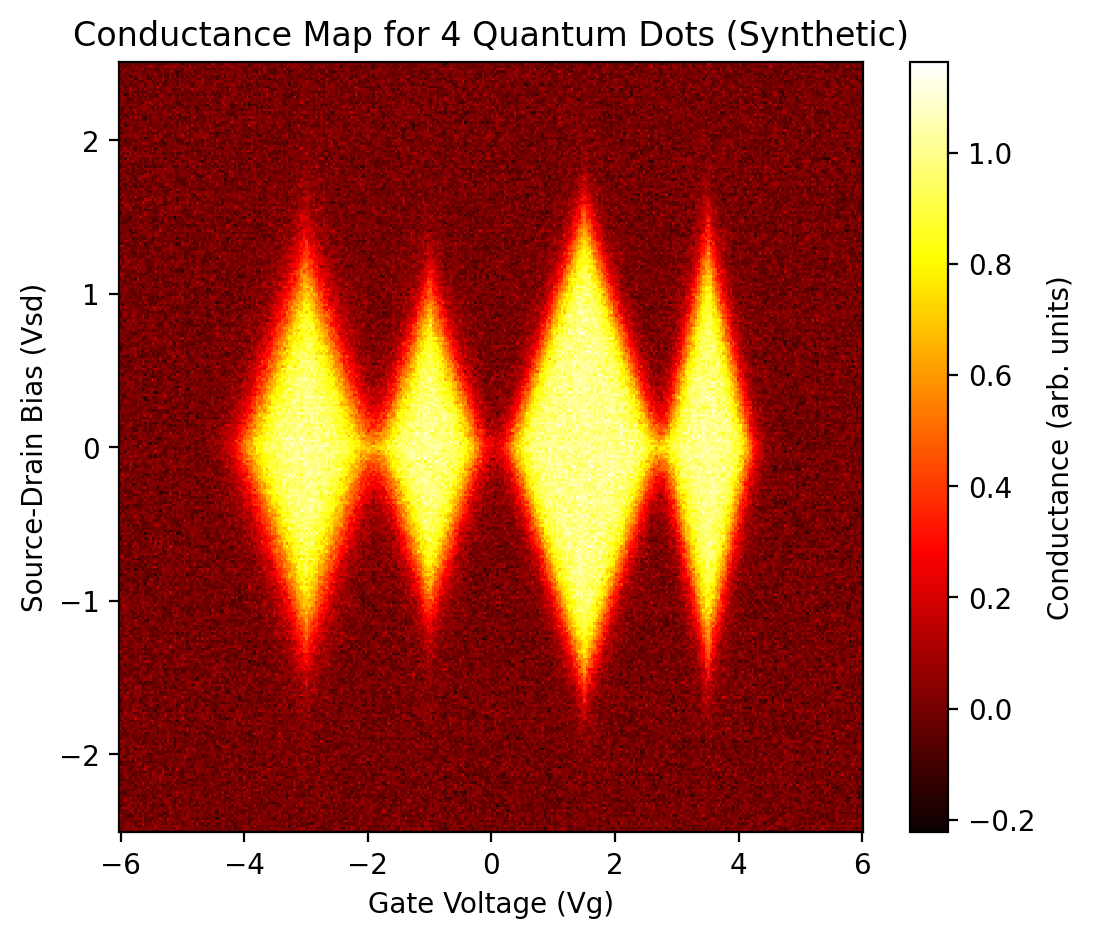

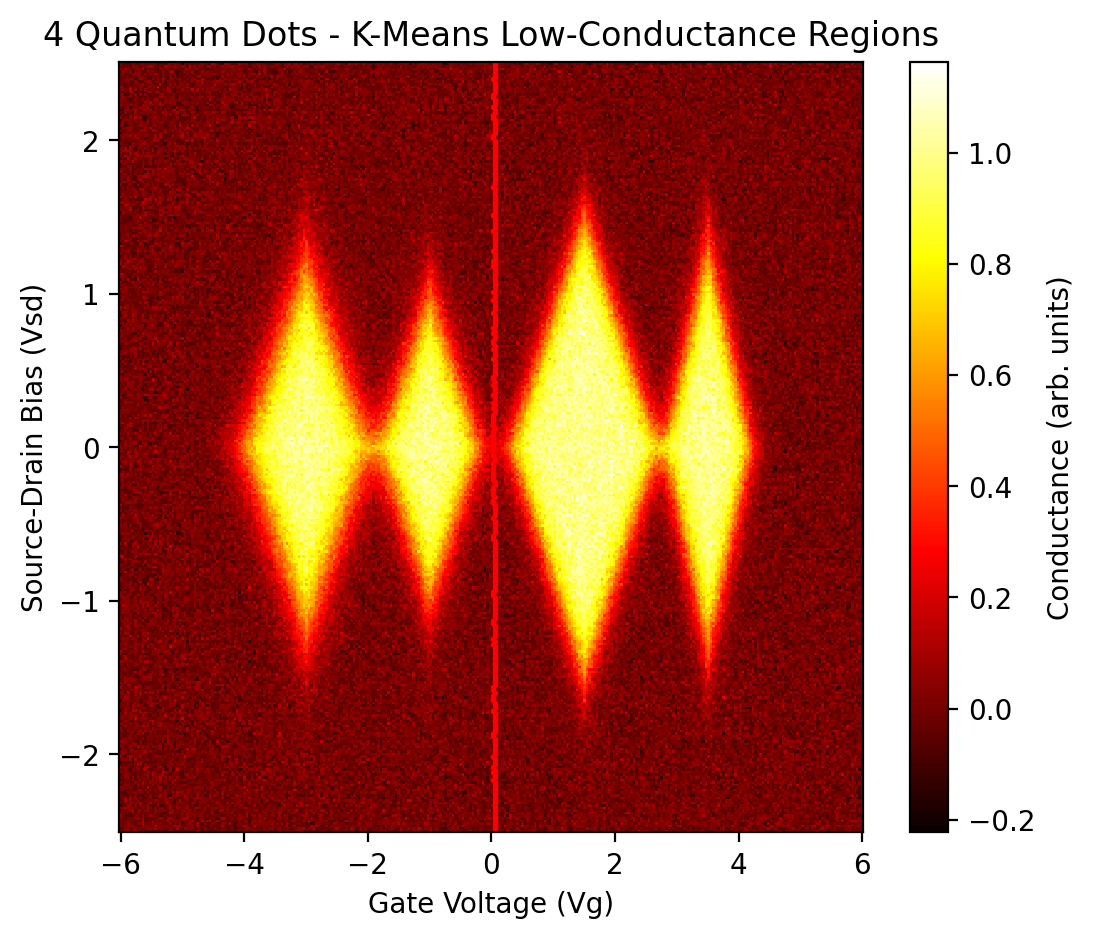

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# ====================================
# 1. Generate synthetic data for 4 QDs
# ====================================
np.random.seed(42)

num_points = 300
Vg = np.linspace(-6, 6, num_points)   # Wider gate voltage range
Vsd = np.linspace(-2.5, 2.5, num_points)
VG, VSD = np.meshgrid(Vg, Vsd)

# Let's define 4 quantum dots, each with its own gate offset and diamond widths
# Dot i: diamond_half_width_gate_i, diamond_half_width_bias_i, offset_i
dot_params = [
    # (gate_half_width, bias_half_width, offset, sharpness)
    (1.0, 1.2, -3.0, 5.0),
    (0.8, 1.0, -1.0, 6.0),
    (1.2, 1.5,  1.5, 7.0),
    (0.7, 1.3,  3.5, 5.5),
]

# We'll create each dot's conduction and sum them
conductance_total = np.zeros_like(VG)

for (gwidth, bwidth, offset, sharpness) in dot_params:
    alpha = bwidth / gwidth
    diamond_cond = np.abs(VSD) + alpha * np.abs(VG - offset)
    conduction_dot = 1 / (1 + np.exp(sharpness * (diamond_cond - bwidth)))
    conductance_total += conduction_dot

# Add noise
noise_amplitude = 0.05
conductance_noisy = conductance_total + noise_amplitude * np.random.randn(*VG.shape)

# =========================
# 2. Plot the 4-dot map
# =========================
fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('Conductance Map for 4 Quantum Dots (Synthetic)')
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')
plt.show()

# ================================================
# 3. K-means to outline the low-conductance region
# ================================================
X_flat = VG.ravel()
Y_flat = VSD.ravel()
C_flat = conductance_noisy.ravel()
data_for_clustering = np.column_stack((X_flat, Y_flat, C_flat))

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(data_for_clustering)
labels_2d = labels.reshape(num_points, num_points)

# Identify the cluster with lower average conduction
avg_conductance_in_cluster = []
for cluster_id in range(2):
    avg_conductance_in_cluster.append(np.mean(C_flat[labels == cluster_id]))
low_cluster_id = np.argmin(avg_conductance_in_cluster)

low_mask = (labels_2d == low_cluster_id)
dilated_mask = binary_dilation(low_mask)
boundary = dilated_mask ^ low_mask

# Plot with the blockade outline
fig, ax = plt.subplots(figsize=(6,5))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')

ax.scatter(VG[boundary], VSD[boundary], color='red', s=1)
ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('4 Quantum Dots - K-Means Low-Conductance Regions')
plt.show()


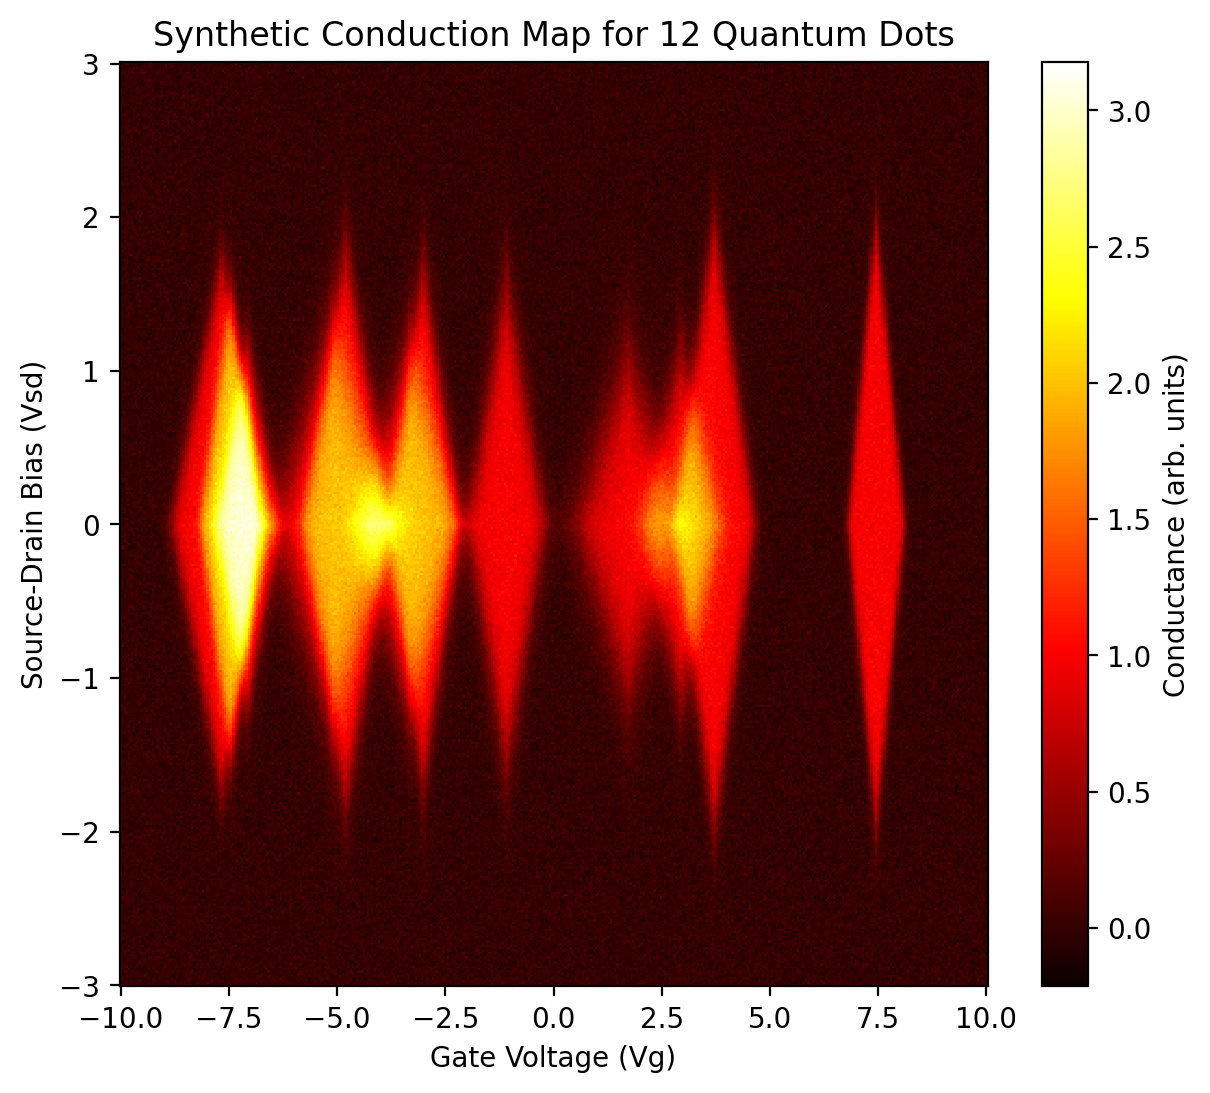

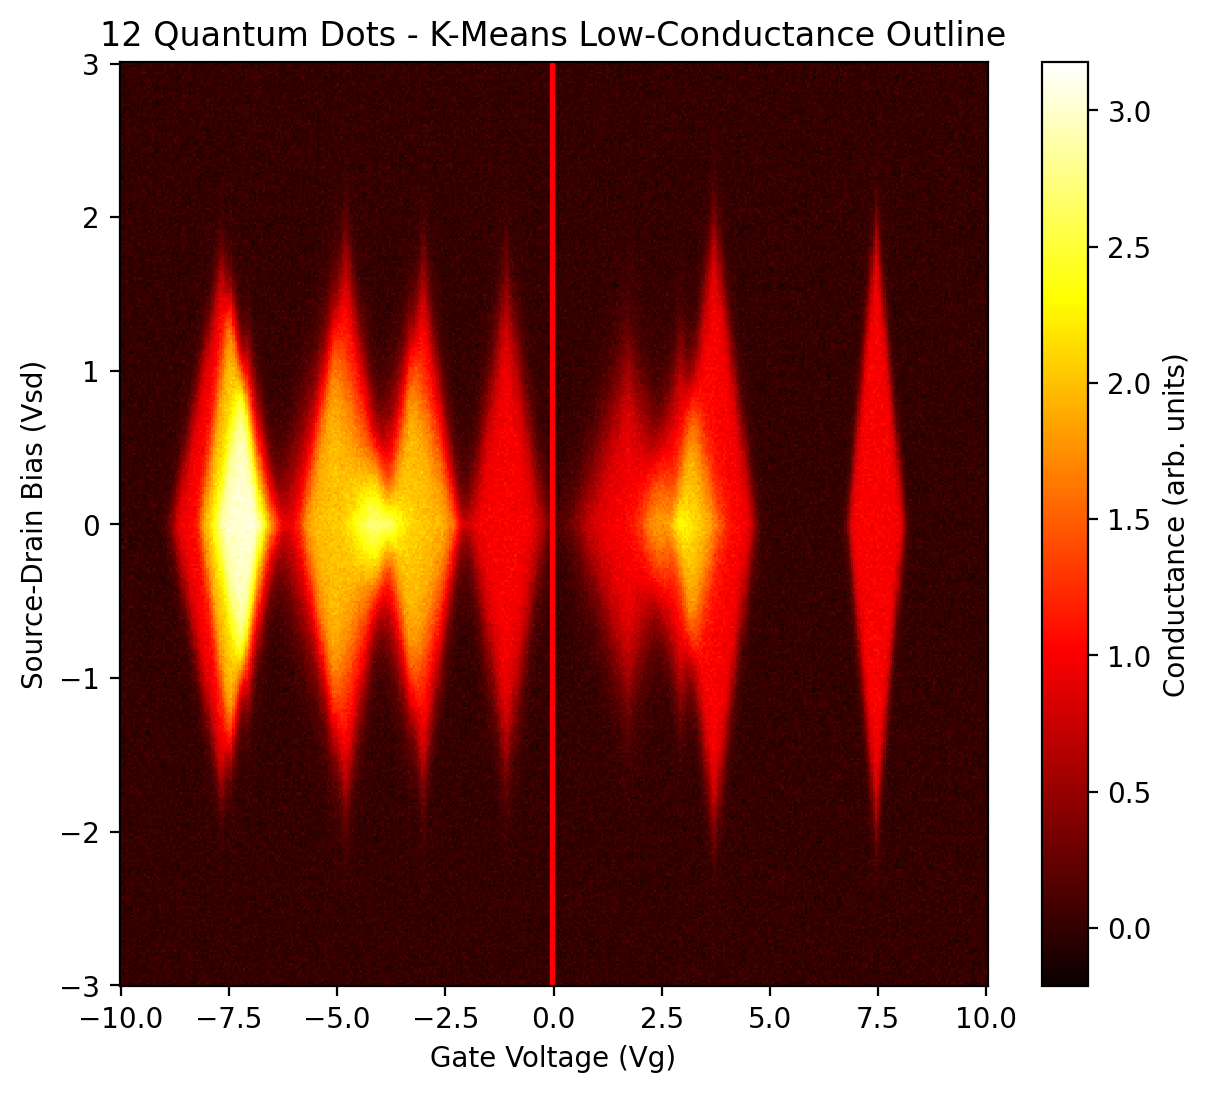

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

# ======================================
# 1. Define simulation parameters
# ======================================
np.random.seed(42)

num_points = 400
Vg = np.linspace(-10, 10, num_points)  # Gate voltage range from -10 to +10
Vsd = np.linspace(-3, 3, num_points)   # Bias range
VG, VSD = np.meshgrid(Vg, Vsd)

# Noise level
noise_amplitude = 0.05

# --------------------------------------
# 1.1 Create an array of dot parameters
# --------------------------------------
# Each dot is defined by: (gate_half_width, bias_half_width, gate_offset, sharpness)
# For variety, let's generate them randomly within some range:
num_dots = 12
dot_params = []
for i in range(num_dots):
    # Random half-width in gate (between 0.6 and 1.5)
    gwidth = np.random.uniform(0.6, 1.5)
    # Random half-width in bias (between 1.0 and 2.0)
    bwidth = np.random.uniform(1.0, 2.0)
    # Random offset in gate voltage (between -8 and +8)
    offset = np.random.uniform(-8, 8)
    # Random sharpness (between 4 and 8)
    sharpness = np.random.uniform(4, 8)
    dot_params.append((gwidth, bwidth, offset, sharpness))

# =========================================
# 2. Generate the total conduction map
# =========================================
# We'll model each dot's blockade by:
#   diamond_condition_i = |Vsd| + alpha_i * |Vg - offset_i|
#   conduction_i        = 1 / (1 + exp( sharpness_i * (diamond_condition_i - bwidth_i) ))
# Then sum them all.

conductance_total = np.zeros_like(VG)

for (gwidth, bwidth, offset, sharpness) in dot_params:
    alpha = bwidth / gwidth
    diamond_cond = np.abs(VSD) + alpha * np.abs(VG - offset)
    conduction_dot = 1 / (1 + np.exp(sharpness * (diamond_cond - bwidth)))
    conductance_total += conduction_dot

# Add random noise
conductance_noisy = conductance_total + noise_amplitude * np.random.randn(*VG.shape)

# =========================================
# 3. Plot the conduction map (12 QDs)
# =========================================
fig, ax = plt.subplots(figsize=(7,6))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('Synthetic Conduction Map for 12 Quantum Dots')
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')
plt.show()

# =======================================================
# 4. K-means to identify low- vs high-conductance regions
# =======================================================
X_flat = VG.ravel()
Y_flat = VSD.ravel()
C_flat = conductance_noisy.ravel()

data_for_clustering = np.column_stack((X_flat, Y_flat, C_flat))

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(data_for_clustering)
labels_2d = labels.reshape(num_points, num_points)

# Identify which cluster is the low-conductance cluster
avg_conductance_in_cluster = []
for cluster_id in range(2):
    avg_conductance_in_cluster.append(np.mean(C_flat[labels == cluster_id]))
low_cluster_id = np.argmin(avg_conductance_in_cluster)

# Create mask + boundary for low-conductance region
low_mask = (labels_2d == low_cluster_id)
dilated_mask = binary_dilation(low_mask)
boundary = dilated_mask ^ low_mask

# Plot the map again with the outline
fig, ax = plt.subplots(figsize=(7,6))
c = ax.pcolormesh(VG, VSD, conductance_noisy, shading='auto', cmap='hot')  # Changed to 'hot'
fig.colorbar(c, ax=ax, label='Conductance (arb. units)')

ax.scatter(VG[boundary], VSD[boundary], color='red', s=1)
ax.set_xlabel('Gate Voltage (Vg)')
ax.set_ylabel('Source-Drain Bias (Vsd)')
ax.set_title('12 Quantum Dots - K-Means Low-Conductance Outline')
plt.show()